In [1]:
"""
Title: Predictive Analysis of UPDRS Scores for Parkinson's Disease Severity
Description: This script processes the combined clinical, peptide, and protein data to train
             a machine learning model for predicting the severity of Parkinson's disease
             as measured by UPDRS scores. The script includes data preprocessing,
             exploratory data analysis, model training and evaluation, hyperparameter tuning,
             and SHAP values interpretation for model explainability.
"""

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel
from scipy.stats import randint, uniform

# SHAP values for model interpretation
import shap

# Loading the dataset
dataset_file_path = '/kaggle/input/dataset/combined.csv'
data = pd.read_csv(dataset_file_path)

# Table 1: Dataset Demographics and Clinical Characteristics
# Used 'patient_id' and 'visit_month' has demographics for simplification
demographics = data[['patient_id', 'visit_month']].copy()
demographics['patient_id'] = demographics['patient_id'].astype(str)  # This step ensures patient_id is treated as a categorical variable

# As per the understanding the 'visit_month' could correspond to 'disease_duration' in months
demographics.rename(columns={'visit_month': 'disease_duration_months'}, inplace=True)

# Summary statistics for demographic data
demographics_summary = demographics.describe(include='all')
print("Table 1: Dataset Demographics and Clinical Characteristics")
print(demographics_summary)

Table 1: Dataset Demographics and Clinical Characteristics
       patient_id  disease_duration_months
count        2615              2615.000000
unique        248                      NaN
top         55096                      NaN
freq           17                      NaN
mean          NaN                31.190822
std           NaN                25.199053
min           NaN                 0.000000
25%           NaN                10.500000
50%           NaN                24.000000
75%           NaN                48.000000
max           NaN               108.000000


In [2]:

# Table 3: Statistical Summary of Key Variables
# Using UPDRS scores and PeptideAbundance_mean has key variables
key_variables = data[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'PeptideAbundance_mean']].copy()
key_variables_summary = key_variables.describe()
print("\nTable 3: Statistical Summary of Key Variables")
print(key_variables_summary)


Table 3: Statistical Summary of Key Variables
           updrs_1     updrs_2      updrs_3      updrs_4  \
count  2614.000000  2613.00000  2590.000000  1577.000000   
mean      7.110559     6.74359    19.421236     1.861763   
std       5.525955     6.32323    15.000289     3.022112   
min       0.000000     0.00000     0.000000     0.000000   
25%       3.000000     1.00000     6.000000     0.000000   
50%       6.000000     5.00000    19.000000     0.000000   
75%      10.000000    10.00000    29.000000     3.000000   
max      33.000000    40.00000    86.000000    20.000000   

       PeptideAbundance_mean  
count           1.068000e+03  
mean            6.438247e+05  
std             9.842238e+04  
min             1.982110e+05  
25%             5.794340e+05  
50%             6.352537e+05  
75%             7.003237e+05  
max             1.069618e+06  


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future

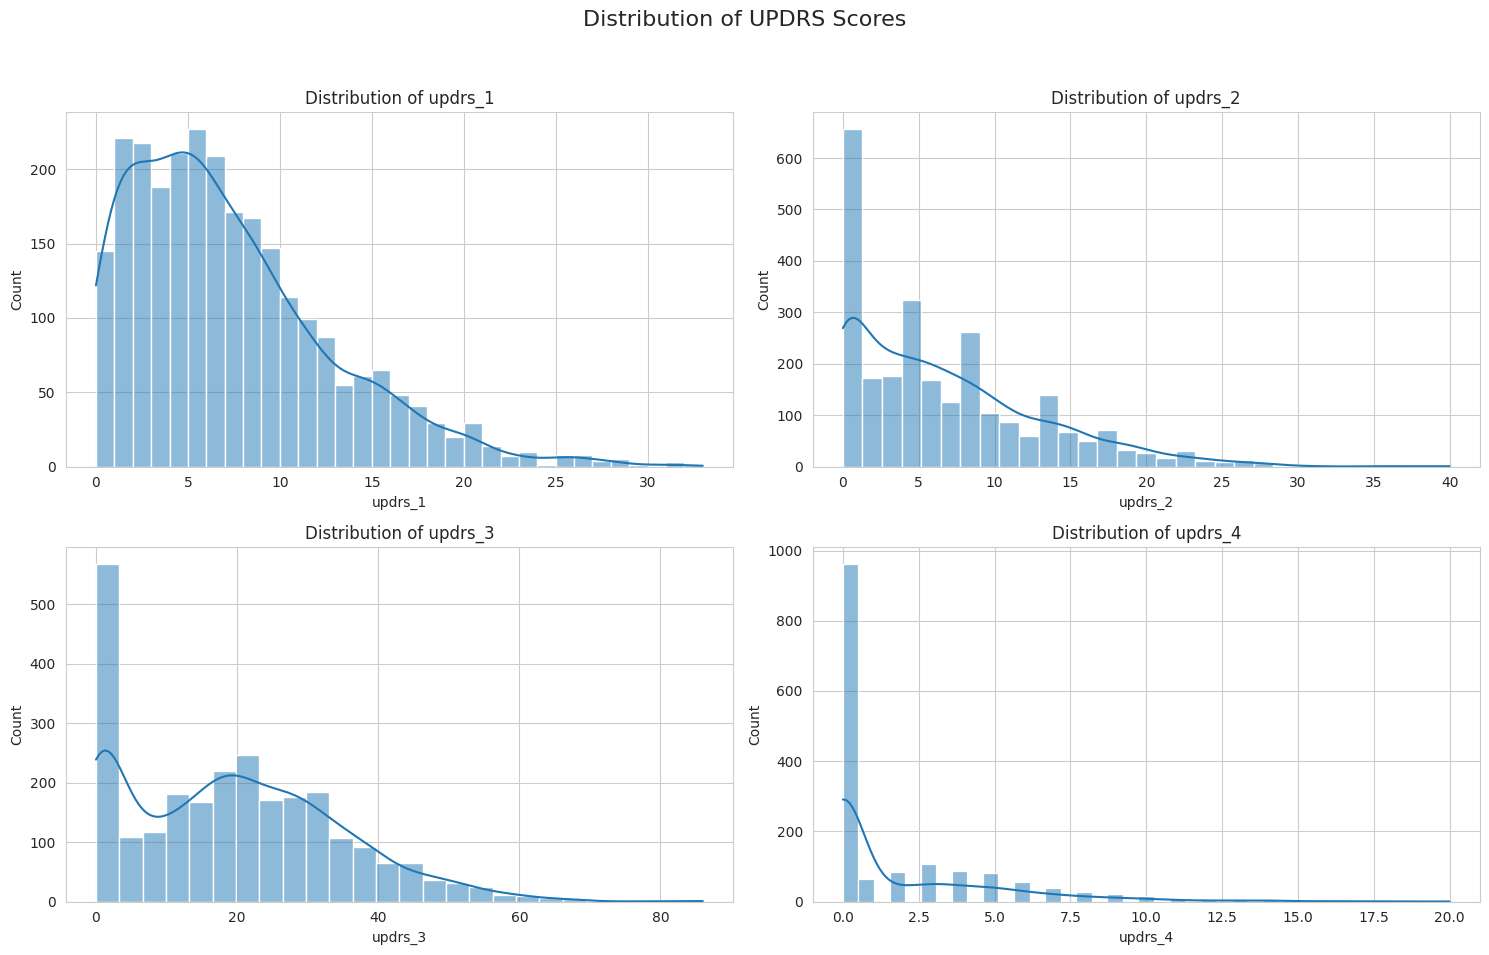

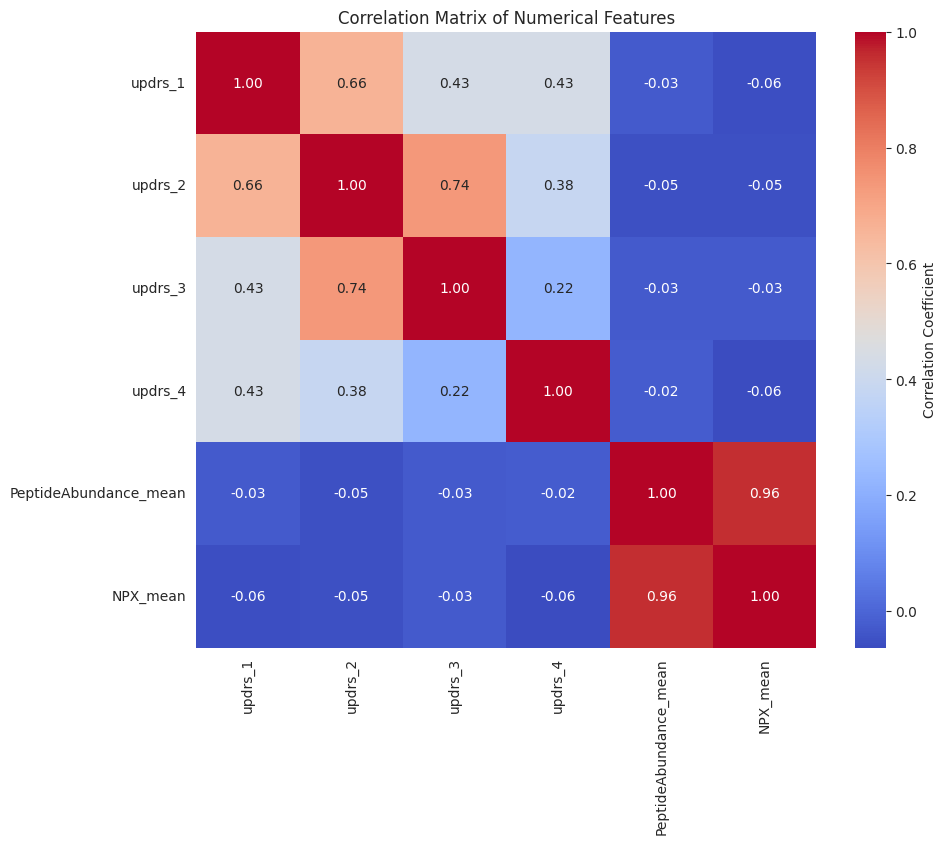

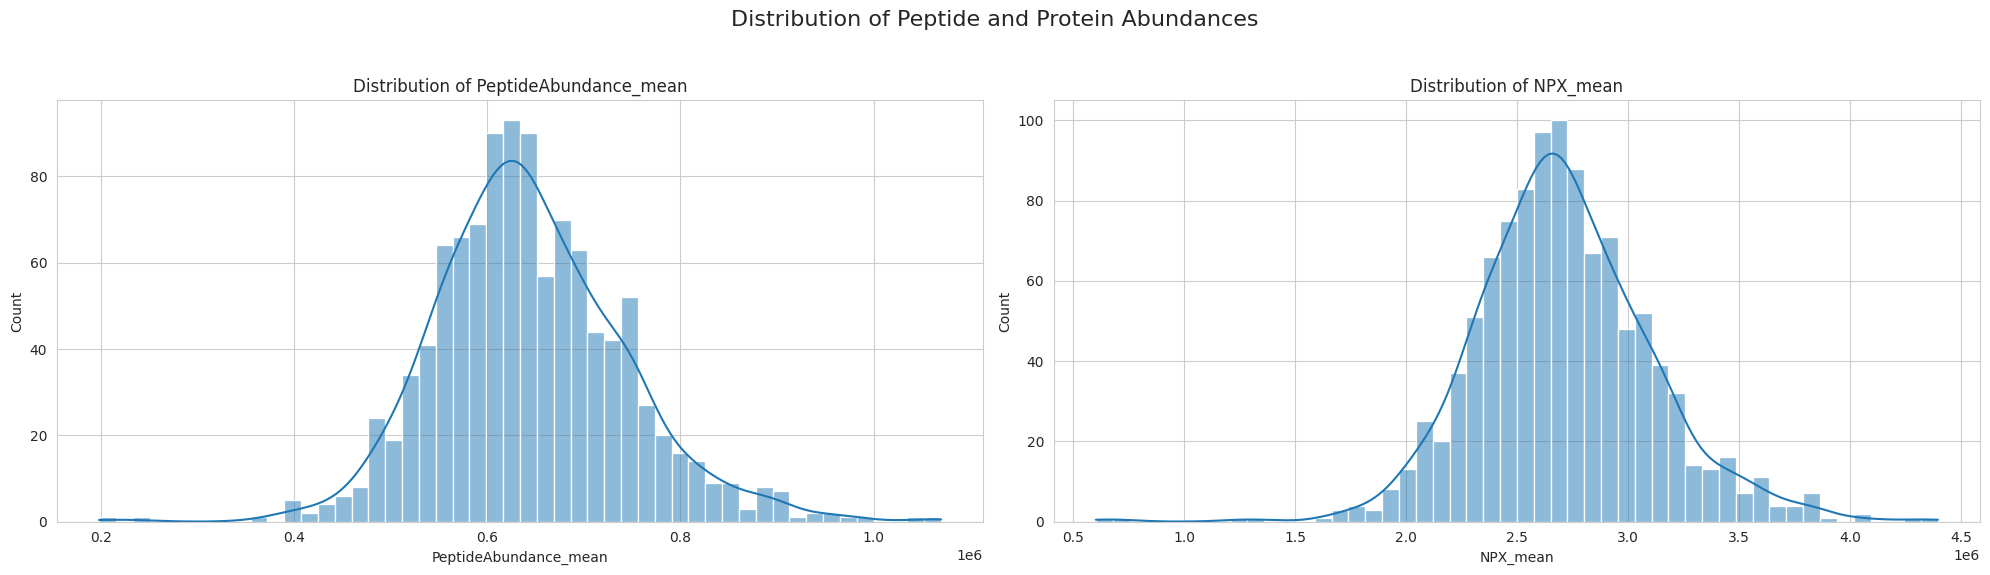

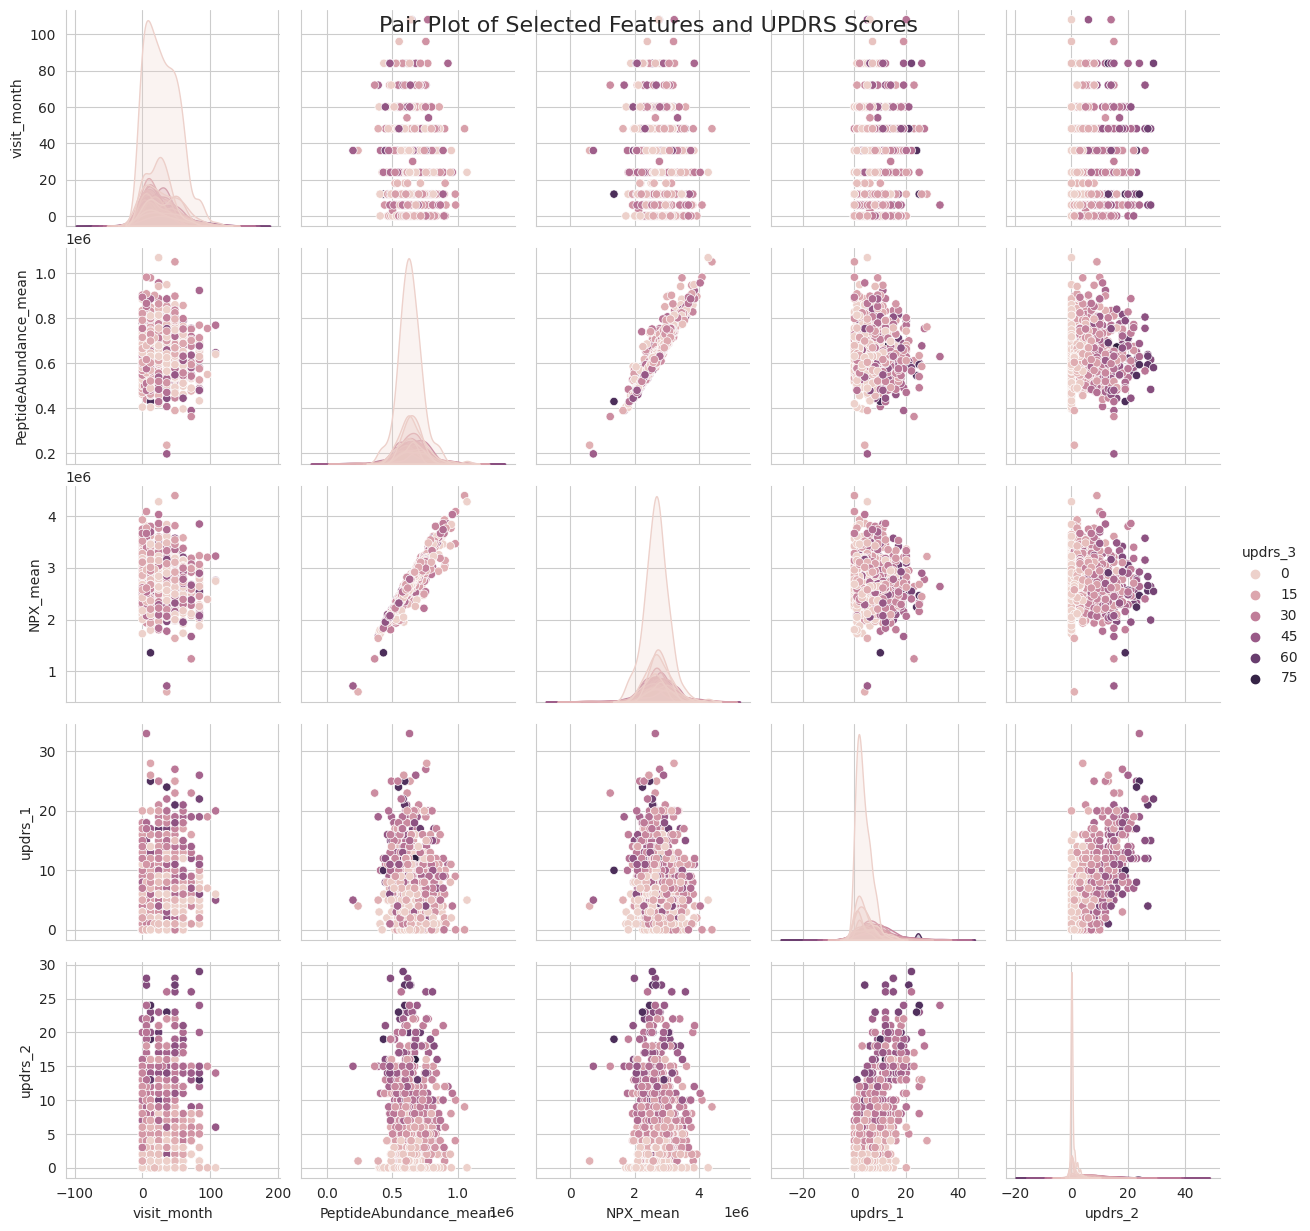

In [3]:

# This is used to set the aesthetic style of the plots
sns.set_style("whitegrid")

# Used Function to create distribution plots for UPDRS scores
def plot_updrs_distributions(data, updrs_columns):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    fig.suptitle('Distribution of UPDRS Scores', fontsize=16)

    for ax, column in zip(axes.flatten(), updrs_columns):
        sns.histplot(data[column], kde=True, ax=ax)
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Count')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # We can adjust the subplots to fit the figure area.

# Used Function to create a correlation matrix heatmap
def plot_correlation_matrix(data, features):
    corr = data[features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
    plt.title('Correlation Matrix of Numerical Features')

# Used Function to create distribution plots for peptide and protein abundances
def plot_abundance_distributions(data, abundance_features):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
    fig.suptitle('Distribution of Peptide and Protein Abundances', fontsize=16)

    for ax, feature in zip(axes.flatten(), abundance_features):
        sns.histplot(data[feature], bins=50, kde=True, ax=ax)
        ax.set_title(f'Distribution of {feature}')
        ax.set_xlabel(feature)
        ax.set_ylabel('Count')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # here we can adjust the subplots to fit the figure area.

# Updated plot_pairplot function to include a check for an empty DataFrame
def plot_pairplot(data, features, hue=None):
    # This step helps us to drop missing values for pairplot and check if the resulting DataFrame is empty
    pairplot_data = data[features].dropna()
    if pairplot_data.empty:
        print(f"No data available to plot after dropping NaN values for features: {features}")
    else:
        sns.pairplot(pairplot_data, hue=hue, diag_kind='kde')
        plt.suptitle('Pair Plot of Selected Features and UPDRS Scores', fontsize=16)

# Here we define the UPDRS columns for distribution plots
updrs_columns = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']

# Here we define the numerical features of the correlation matrix
numerical_features = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'PeptideAbundance_mean', 'NPX_mean']

# Here we define the features of the abundance distributions
abundance_features = ['PeptideAbundance_mean', 'NPX_mean']

# Here we define the features of the pair plot
pairplot_features = ['visit_month', 'PeptideAbundance_mean', 'NPX_mean', 'updrs_1', 'updrs_2']

# Now, calling the plotting functions with these defined variables
plot_updrs_distributions(data, updrs_columns)
plot_correlation_matrix(data, numerical_features)
plot_abundance_distributions(data, abundance_features)
plot_pairplot(data, pairplot_features + ['updrs_3'], hue='updrs_3')  # Adding 'updrs_3' to the pair plot features

plt.show()  # This code helps to display all the plots generated so far



In [4]:
# Preprocessing
# Here we define the target variable and columns
target = 'updrs_3'
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove(target)

# This Ensures no missing values in the target variable before the train-test split
data = data.dropna(subset=[target])

# Here we define features and target
X = data.drop(columns=[target])
y = data[target]
    
# Here we've split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
# Note: We are using SimpleImputer only on features (X), not on the target (y)
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', SimpleImputer(strategy='mean'), numerical_cols)
    ],
    remainder='passthrough'
)

# Machine learning pipelines
# This step creates machine learning pipelines
rf_pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('scaler', StandardScaler(with_mean=False)), # If features are sparse we can set with_mean=False
    ('model', RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1))
])

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('scaler', StandardScaler(with_mean=False)), # If features are sparse we can set with_mean=False
    ('model', XGBRegressor(n_estimators=10, random_state=42, n_jobs=-1))
])

# Model training and evaluation
# This Performs cross-validation for RandomForest and XGBoost
rf_cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='r2')
xgb_cv_scores = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring='r2')

# Print cross-validation results
print("Random Forest CV R2 scores:", rf_cv_scores)
print("Average Random Forest CV R2:", rf_cv_scores.mean())
print("XGBoost CV R2 scores:", xgb_cv_scores)
print("Average XGBoost CV R2:", xgb_cv_scores.mean())

# Selecting the best model based on cross-validation scores
best_pipeline = rf_pipeline if rf_cv_scores.mean() > xgb_cv_scores.mean() else xgb_pipeline
# This step fits the best model on the training data
best_pipeline.fit(X_train, y_train)

# Here we evaluate the best model on the test data
final_predictions = best_pipeline.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
final_r2 = r2_score(y_test, final_predictions)
print("Final Model RMSE:", final_rmse)
print("Final Model R2:", final_r2)



Random Forest CV R2 scores: [0.61322988 0.67143389 0.58212555 0.58880145 0.67683062]
Average Random Forest CV R2: 0.6264842802470859
XGBoost CV R2 scores: [0.64574527 0.70196896 0.65226425 0.6236141  0.69485336]
Average XGBoost CV R2: 0.6636891879086068
Final Model RMSE: 8.389961465388696
Final Model R2: 0.6672181340437556


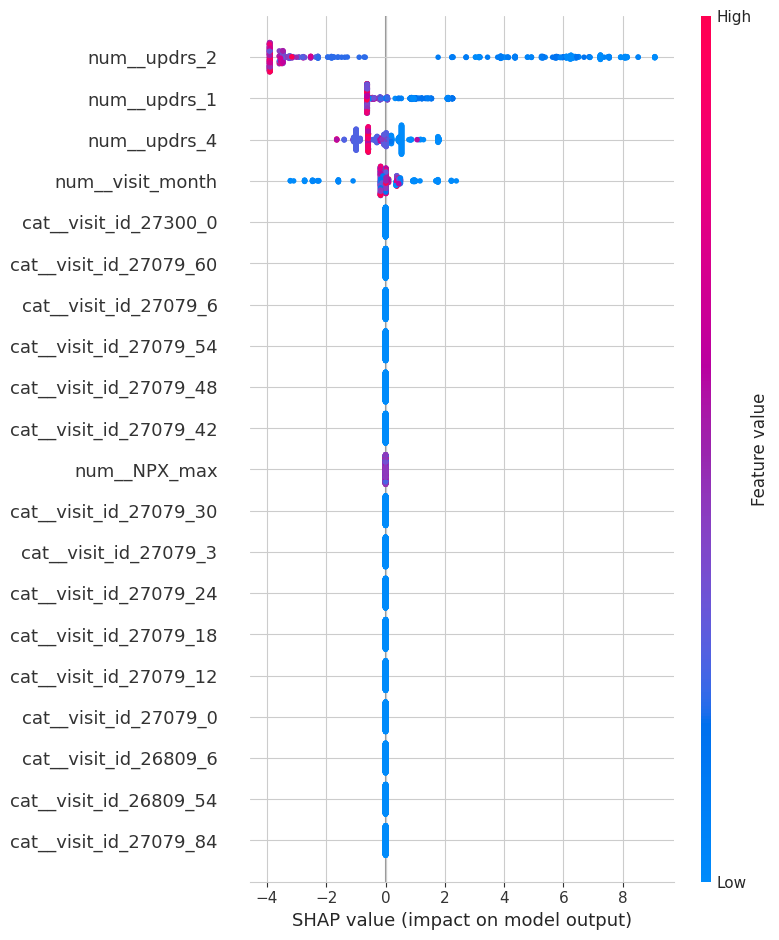

<Figure size 640x480 with 0 Axes>

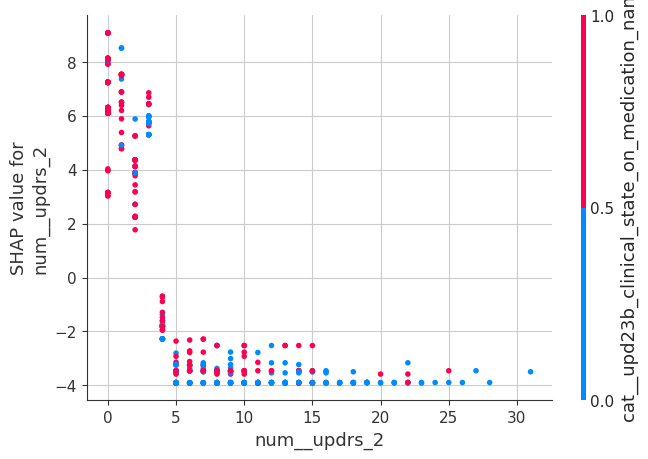

In [5]:
from scipy.sparse import issparse

# This step helps in ensuring X_train_transformed and X_test_transformed are dense arrays if they are sparse
X_train_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)
if issparse(X_train_transformed):
    X_train_transformed = X_train_transformed.toarray()

X_test_transformed = best_pipeline.named_steps['preprocessor'].transform(X_test)
if issparse(X_test_transformed):
    X_test_transformed = X_test_transformed.toarray()

# Creates the SHAP explainer using the transformed training set
explainer = shap.Explainer(best_pipeline.named_steps['model'], X_train_transformed)

# This step calculates SHAP values using the transformed test set
shap_values = explainer.shap_values(X_test_transformed)

# Get feature names from the preprocessor step (after OneHotEncoding and other transformations)
feature_names_transformed = best_pipeline.named_steps['preprocessor'].get_feature_names_out()

# This step plots the SHAP summary plot using the transformed feature names
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names_transformed)

# Save the SHAP summary plot
plt.savefig('shap_summary_plot.png')

# This step plots SHAP dependence for 'updrs_2'
shap.dependence_plot('num__updrs_2', shap_values, X_test_transformed, feature_names=feature_names_transformed)


In [6]:
# We have used SelectFromModel as feature selection here
selector = SelectFromModel(estimator=XGBRegressor(n_estimators=100, random_state=42), threshold='median')
X_train_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)
selector.fit(X_train_transformed, y_train)

# Here we update the pipeline to include feature selection
final_pipeline = Pipeline(steps=[
    ('preprocessor', best_pipeline.named_steps['preprocessor']),
    ('feature_selection', selector),
    ('model', best_pipeline.named_steps['model'])
])

# Hyperparameter tuning with RandomizedSearchCV and addressed as param
param_distributions = {
    'model__n_estimators': randint(50, 150),
    'model__max_depth': randint(3, 10),
    'model__learning_rate': uniform(0.01, 0.2)
}

# Initializing RandomizedSearchCV
random_search = RandomizedSearchCV(
    final_pipeline, 
    param_distributions=param_distributions, 
    n_iter=50, 
    scoring='r2', 
    cv=5, 
    random_state=42, 
    n_jobs=-1
)

# Fitting RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'model__learning_rate': 0.13367720186661747, 'model__max_depth': 6, 'model__n_estimators': 104}
Best Score: 0.6864089156104776


In [7]:
# Setting the best parameters for the model in the pipeline
final_pipeline.set_params(model__learning_rate=0.14318447132349935, 
                          model__max_depth=6, 
                          model__n_estimators=135)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['visit_id',
                                                   'upd23b_clinical_state_on_medication']),
                                                 ('num', SimpleImputer(),
                                                  ['patient_id', 'visit_month',
                                                   'updrs_1', 'updrs_2',
                                                   'updrs_4',
                                                   'PeptideAbundance_mean',
                                                   'PeptideAbundance_median',
                                                   'PeptideAbundance_std',
                                                   'PeptideAb...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.14318447132349935, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=135, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [8]:
# In this step we are trying to fit the final model on the entire training data
final_pipeline.set_params(**random_search.best_params_)
final_pipeline.fit(X_train, y_train)

# We make predictions on the test data with final model
final_predictions = final_pipeline.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
final_r2 = r2_score(y_test, final_predictions)
print("Final Model RMSE:", final_rmse)
print("Final Model R2:", final_r2)

Final Model RMSE: 8.061214938639445
Final Model R2: 0.6927861985130394
